Programming Exercise 4: Neural Networks Learning

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm # used to display images in a specific colormap
import scipy.io # used to load *.mat files
import scipy.optimize # fmin_cg to train neural network
import pandas as pd
import itertools
import random
from scipy.special import expit # vectorized sigmoid function
from PIL import Image # used to show matirx as an image


1 Neural Networks

1.1 Visualising the data

In [3]:
datafile = 'ex4data1.mat'
mat = scipy.io.loadmat(datafile)
X, Y = mat['X'], mat['y']

# insert a column of 1's x
X = np.insert(X, 0, 1, axis=1)

print ("'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape, np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s"%(X.shape, X[0].shape))
# X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
# Y is a classification for each image. 1-10, where "10" is the handwritten "0"

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [4]:
def getDatumImg(row):
    """
    function that is handed a single np array with shape 1x400,
    creates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width, height)
    return square.T
    

In [15]:
def displayData(indicies_to_display = None):
    """
    function that picks 100 random rows from X, creates a 20x20 image from each,
    then stiiches them together into a 10x10 grid of images, and shows it
    """
    
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indicies_to_display:
        indicies_to_display = random.sample(range(X.shape[0]), nrows*ncols)
    
    # height*nrows => 20*10 => 每张image的height为20px * 显示20行
    # 生成一个可以放下所有的image的figure
    big_picture = np.zeros((height*nrows, width*ncols))
    
    # 设置image在big_picture中的位置
    irow, icol = 0, 0
    for idx in indicies_to_display:
        if icol == ncols:
            irow += 1;
            icol  = 0;
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    
    fig = plt.figure(figsize=(6,6))
    img = Image.fromarray(big_picture)
    plt.imshow(img, cmap=cm.Greys_r)
    

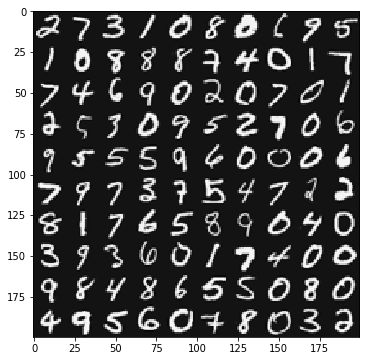

In [16]:
displayData()

1.2 Model representation

In [18]:
# 注：该模型input ø1-> 一层hidden layer ø2-> output layer
# You have been provided with a set of network parameters (Θ(1),Θ(2)) 
# already trained by us. These are stored in ex4weights.mat
datafile = 'ex4weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
# The matrices Theta1 and Theta2 will now be in your workspace
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26


In [19]:
# global variables and not including bias unit
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10
n_training_samples = X.shape[0]


In [41]:
# utility functions 公用方法
# There are a lot of flattening使变平 and reshaping of theta matrices
# the input X matrix, etc...
# Nicely shaped matrices make the linear algebra代数 easier when developing,
# but the minimization routine (fmin_cg) requires that all inputs

# 生成一维
def flattenParams(thetas_list):
    """
    hand this function a list of theta matrices, and it will flatten
    it into one long (n,1) shaped numpy array
    """
    # 循环取出thetas_list，并变成一维数组
    flattened_list = [mytheta.flatten() for mytheta in thetas_list]
    combined = list(itertools.chain.from_iterable(flattened_list))

    # assert断言，True时发动
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [ theta1, theta2 ]

def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))



1.3 FeedForward and cost function

In [44]:
def computeCost(mythetas_flattened, myX_flattened, myY, myLambda=0.):
    """
    This function takes in采取:
        1) a flattened vector of theta parameters (each theta would go from one
           NN layer to the next), the theta include the bias unit
        2) the flattened training set matrix X, which contains the bias unit first column
        3) the label vector Y, which has one column
    It loops over training points and :
        1) contructs a new "y" vector, with 10 rows and 1 column,
           with one non-zero entry非零项 corresponding to对应 that iteration
        2) computes the cost given that y-vector and that training point
        3) accumulates堆积 all of the costs
        4) computes a regularization term (after the loop over training points)
    """
    
    # First unroll展开 the parameters
    mythetas = reshapeParams(mythetas_flattened)

    # Now unroll X
    myX = reshapeX(myX_flattened)
    
    # This is what will accumulate the total cost
    total_cost = 0.
    
    m = n_training_samples
    
    # Loop over the training points (rows on myX, already contrain bias unit)
    # cost 求和 => K次（output units）
    for irow in range(m):
        myrow = myX[irow]
        
        # hø(X) => hypothesis
        # First compute hypothesis (this is a (10,1) vector
        # of the hypothesis for each possible y-value)
        # porpagateForward returns (za, activation) for each layer
        # so propagateforward[-1][1] means "activation for -1st (last) layer"
        myhs = propagateForward(myrow, mythetas)[-1][1]
        
        # Construct a 10x1 "y" vector with all zeros and only one "1" entry
        # note: here if the hand-written digit is "0", then that corresponds
        # to a y-vector with 1 in the 10th spot
        tmpy = np.zeros((10, 1)) # y有10 rows
        tmpy[myY[irow] - 1] = 1
        """
        y = [1 [0
             0  1
             0  0
             .  .
             .  .
             .  .
             0] 0] ... 每一种方式代表一个结果
        """ 
        
        # compute the cost for this point and y-vector
        # logistic cost function
        mycost = -tmpy.T.dot(np.log(myhs)) - (1-tmpy.T).dot(np.log(1-myhs))
        
        # accumulate the total cost
        total_cost += mycost
    
    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m
    
    # compute the regularization term
    # 正则化，sum(øj^2)
    total_reg = 0
    for mytheta in mythetas:
        total_reg += np.sum(mytheta*mytheta) # element-wise multiplication
    total_reg *= float(myLambda) / (2*m)
        
    return total_cost + total_reg


In [45]:
def propagateForward(row, Thetas):
    """
    Function that given a list of Thetas (not flattened), propagates the
    row of features forwards, assuming the feature ALREADY
    include the bias unit in the input layer, and the 
    Thetas also include the bias unit
    将features向前传播
    
    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element id a tuple of (za, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    *** 
    The 'activations' are the same as "h", but this works for many layers
    (hence a vector of theta, not just one theta)
    Also, 'h' is vectorized to do all rows at once ...
    this fucntion takes in one row at a time 
    ***
    """
    
    features = row
    zs_as_per_layer = []
    
    for i in range(len(Thetas)):
        Theta = Thetas[i]
        # Theta is (25,401), features are (401, 1)
        # so "z" comes out to be (25,1)
        # this is one "z" value for each unit in the hidden layer
        # not counting the bias unit
        z = Theta.dot(features).reshape((Theta.shape[0], 1))
        a = expit(z)
        zs_as_per_layer.append((z,a))
        if i == len(Thetas)-1:
            return np.array(zs_as_per_layer)

        a = np.insert(a, 0, 1) # add the bias unit
        features = a


In [49]:
print (len(Theta1), len([ Theta1, Theta2 ]))

25 2


In [46]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#you should see that the cost is about 0.287629
myThetas = [ Theta1, Theta2 ]

#Note I flatten the thetas vector before handing it to the computeCost routine,
#as per the input format of the computeCost function.
#It does the unrolling/reshaping itself
#I also flatten the X vector, similarly
print (computeCost(flattenParams(myThetas), flattenX(X), Y))


0.2876291651613187


1.4 Regularized cost function

In [53]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#and lambda = 1, you should see that the cost is about 0.383770
myThetas = [ Theta1, Theta2 ]
print (computeCost(flattenParams(myThetas),flattenX(X),Y,myLambda=1.))


0.38448779624289375


2 Backpropagation

2.1 Sigmoid gradient

In [59]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

2.2 Ramdon initialization

In [80]:
# initialize each ø to a random value in [-epsilon, opsilon] <= symmetry breaking打破对称性
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size + 1)
    theta2_shape = (output_layer_size, hidden_layer_size + 1)
    
    # This range of values ensures that the parameters are kept small and makes the learning more efficient.
    rand_thetas = [np.random.rand(*theta1_shape) * 2 * epsilon_init - epsilon_init, \
                   np.random.rand(*theta2_shape) * 2 * epsilon_init - epsilon_init]
    
    return rand_thetas
    

2.3 Backpropagation

In [71]:
def propagateBack(mythetas_flattened, myX_flattened, myY, myLambda=0.):
    
    # first unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # unroll X
    myX = reshapeX(myX_flattened)
    
    # note: the Delta matrices should include the bias unit
    # the delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size, input_layer_size+1))
    Delta2 = np.zeros((output_layer_size, hidden_layer_size+1))
    
    # loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in range(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size+1, 1))
        # propagateForward returns (z's=>ø*x, a's=>g(ø*x)) for each layer excluding the input layer
        temp = propagateForward(myrow, mythetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        
        tmpy = np.zeros((10, 1))
        tmpy[myY[irow]-1] = 1
        """
        y = [1 [0
             0  1
             0  0
             .  .
             .  .
             .  .
             0] 0] ... 每一种方式代表一个结果
        """ 
        
        # aj3 - yj
        delta3 = a3 - tmpy
        # (ø2.T * delta3) .* (a3 .* (1-a3))   .* => 两个向量对象对应位置相乘
        delta2 = mythetas[1].T[1:,:].dot(delta3)*sigmoidGradient(z2) # remove 0th element
        a2 = np.insert(a2, 0, 1, axis=0)
        
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1 / float(m)
    D2 = Delta2 / float(m)
        
    #Regularization:
    D1[:,1:] = D1[:,1:] + (float(myLambda)/m)*mythetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(myLambda)/m)*mythetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()    
        

In [72]:
#Actually compute D matrices for the Thetas provided
flattenedD1D2 = propagateBack(flattenParams(myThetas), flattenX(X), Y, myLambda=0.)
D1, D2 = reshapeParams(flattenedD1D2)


2.4 Gradient Checking

In [76]:
# 用数值的方法计算偏导
def gradientChecking(mythetas, myDs, myX, myY, myLambda=0.):
    myeps = 0.0001
    flattened = flattenParams(mythetas)
    flattenedDs = flattenParams(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened)
    
    # pick 10 random elements, compute numetical gradient , compare to respective D's
    for i in range(10):
        x = int(np.random.rand() * n_elems)
        epsvec = np.zeros((n_elems, 1))
        epsvec[x] = myeps
        # J(theta + epsilon)
        cost_high = computeCost(flattened + epsvec, myX_flattened, myY, myLambda)
        # J(theta - epsilon)
        cost_low  = computeCost(flattened - epsvec, myX_flattened, myY, myLambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        
        print ("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x]))
    
    

In [77]:
gradientChecking(myThetas, [D1, D2], X, Y)

Element: 6505. Numerical Gradient = 0.000082. BackProp Gradient = 0.000082.
Element: 2481. Numerical Gradient = -0.000001. BackProp Gradient = -0.000001.
Element: 4337. Numerical Gradient = -0.000096. BackProp Gradient = -0.000096.
Element: 9141. Numerical Gradient = 0.000003. BackProp Gradient = 0.000003.
Element: 1029. Numerical Gradient = 0.000261. BackProp Gradient = 0.000261.
Element: 2598. Numerical Gradient = -0.000219. BackProp Gradient = -0.000219.
Element: 3395. Numerical Gradient = -0.000468. BackProp Gradient = -0.000468.
Element: 3123. Numerical Gradient = 0.000228. BackProp Gradient = 0.000228.
Element: 6745. Numerical Gradient = 0.000017. BackProp Gradient = 0.000017.
Element: 5977. Numerical Gradient = -0.000001. BackProp Gradient = -0.000001.


2.5 Learning parameters using fmincg

In [78]:
# here using scipy.opitimize.fmin_cg

In [93]:
def trainNN(myLambda=0.):
    """
    function that generate ramdon initial theta matrices, optimize them,
    and returns a list of two re-shaped theta matrices
    """
    
    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=propagateBack, \
                                    args=(flattenX(X), Y, myLambda), maxiter=50, disp=True, full_output=True)
    return reshapeParams(result[0])
    

In [94]:
# training the NN
learned_Thetas = trainNN()

         Current function value: 0.304234
         Iterations: 50
         Function evaluations: 112
         Gradient evaluations: 112


In [83]:
#If your implementation is correct, you should see a reported training accuracy of about 95.3%
#(this may vary by about 1% due to the random initialization).


In [95]:
def predictNN(row, Thetas):
    """
    function that takes a row of features, propagates them through the NN,
    and returns the predicted integer that was handwritten
    """
    classes = range(1, 11)
    output = propagateForward(row, Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in range(n_total):
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print ("Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total)))

In [96]:
computeAccuracy(X, learned_Thetas, Y)

Training set accuracy: 96.2%


In [ ]:
#Let's see if I set lambda to 10, if I get the same thing
learned_regularized_Thetas = trainNN(mylambda=10.)


In [ ]:
computeAccuracy(X, learned_regularized_Thetas, Y)

3 Visulizing the hidden layer

In [101]:
def displayHiddenLayer(myTheta):
    """
    function that takes slices of the first theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into 20x20 image, and show it
    """
    
    # remove bias unit
    myTheta = myTheta[:, 1:]
    assert myTheta.shape == (25, 400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
    
    big_picture = np.zeros((height*nrows, width*ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    
    fig = plt.figure(figsize=(6,6))
    img = Image.fromarray(big_picture)
    plt.imshow(img,cmap = cm.Greys_r)
    
    

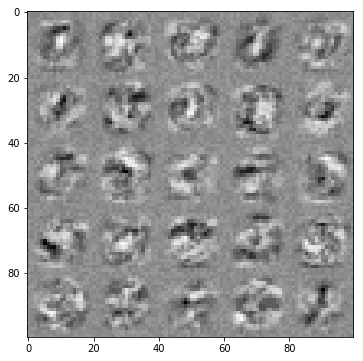

In [102]:
displayHiddenLayer(learned_Thetas[0])